In [1]:
%pip install ipywidgets

/Users/saeedsaadatipour/Git/ImageAlfred/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
from io import BytesIO

import matplotlib.pyplot as plt
import modal
import numpy as np
from PIL import Image


In [3]:
app = modal.App("ImageAlfread")

cuda_version = "12.4.0"
flavor = "devel"
operating_sys = "ubuntu22.04"
tag = f"{cuda_version}-{flavor}-{operating_sys}"

In [4]:
image = (
    modal.Image.from_registry(f"nvidia/cuda:{tag}", add_python="3.12")
    .apt_install("git")
    .pip_install(
        "opencv-contrib-python",
        "huggingface-hub",
        "Pillow",
        "numpy",
        # "opencv-contrib-python-headless",
    )
    .pip_install(
        "torch==2.4.1",
        "torchvision==0.19.1",
        index_url="https://download.pytorch.org/whl/cu124",
        gpu="T4",
    )
    .pip_install("git+https://github.com/luca-medeiros/lang-segment-anything.git",gpu="T4")
)

In [16]:
@app.function(
    gpu="T4",
    image=image,
)
def change_color_objects_image(
    image: Image.Image,
    prompt: str,
    new_hue: int,
    new_saturation=None,
) -> bytes:
    """
    Changes the hue of an object in an image using a soft mask.

    Parameters:
    - image: PIL.Image
    - results: SAM2 model output
    - new_hue: int (0-179, OpenCV hue range)
    - new_saturation: int or None — if provided, overrides object saturation

    Returns:
    - PIL.Image with modified object color
    """
    import cv2  # type: ignore
    from lang_sam import LangSAM  # type: ignore

    model = LangSAM(sam_type="sam2.1_hiera_large")
    results = model.predict(
        images_pil=[image],
        texts_prompt=[prompt],
        # box_threshold=0.3,
        # text_threshold=0.25,
    )

    # Create class_id for each unique label
    unique_labels = list(set(results[0]["labels"]))
    class_id_map = {label: idx for idx, label in enumerate(unique_labels)}
    class_id = [class_id_map[label] for label in results[0]["labels"]]

    mask = results[0]["masks"][0]
    mask = np.clip(mask, 0.0, 1.0)

    # Convert mask to uint8 for contour detection
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Find contours and draw filled mask for smoother shape
    contours, _ = cv2.findContours(
        mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    clean_mask = np.zeros_like(mask_uint8)
    cv2.drawContours(
        clean_mask, contours, -1, 255, thickness=cv2.FILLED, lineType=cv2.LINE_AA
    )
    # Feather the mask with Gaussian blur for soft edges
    feathered_mask = cv2.GaussianBlur(clean_mask, (25, 25), 0) / 255.0
    mask_3ch = np.repeat(feathered_mask[:, :, np.newaxis], 3, axis=2)

    # Convert PIL image to OpenCV format
    bgr_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # Apply changes in masked regions only
    h = h.astype(np.float32)
    s = s.astype(np.float32)

    h = feathered_mask * new_hue + (1 - feathered_mask) * h
    if new_saturation is not None:
        s = feathered_mask * new_saturation + (1 - feathered_mask) * s
    # Clip and convert back to uint8
    h = np.clip(h, 0, 179).astype(np.uint8)  # Hue range in OpenCV is [0, 179]
    s = np.clip(s, 0, 255).astype(np.uint8)

    # Merge channels and convert back to BGR
    hsv_modified = cv2.merge([h, s, v])
    colored_bgr = cv2.cvtColor(hsv_modified, cv2.COLOR_HSV2BGR)

    # Convert colored_bgr and original bgr_image to RGB for blending
    colored_rgb = cv2.cvtColor(colored_bgr, cv2.COLOR_BGR2RGB)
    original_rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Blend in RGB space using soft mask
    output_rgb = (
        colored_rgb.astype(np.float32) * mask_3ch
        + original_rgb.astype(np.float32) * (1 - mask_3ch)
    ).astype(np.uint8)

    # Convert back to Pillow Image
    result_pil = Image.fromarray(output_rgb)

    return result_pil

In [15]:
@app.function(gpu="T4", image=image)
def langsam_segment(
    image: Image.Image,
    prompt: str,
) -> list:
    from lang_sam import LangSAM  # type: ignore

    model = LangSAM(sam_type="sam2.1_hiera_large")
    results = model.predict([image], [prompt])
    return results


In [17]:
input_dir = "./src/assets/input"
output_dir = "./src/assets/output"
img_name = "test_1.jpg"
img = Image.open(f"{input_dir}/{img_name}").convert("RGB")

In [21]:
masks = None
with app.run():
    masks = langsam_segment.remote(img, "pants.")


In [23]:
masks

[{'scores': array([0.6627965], dtype=float32),
  'labels': ['pants'],
  'boxes': array([[ 386.53082, 1656.1442 , 1006.8546 , 1927.3484 ]], dtype=float32),
  'masks': array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
        shape=(1, 1930, 1340), dtype=float32),
  'mask_scores': array(0.9921875, dtype=float32)}]

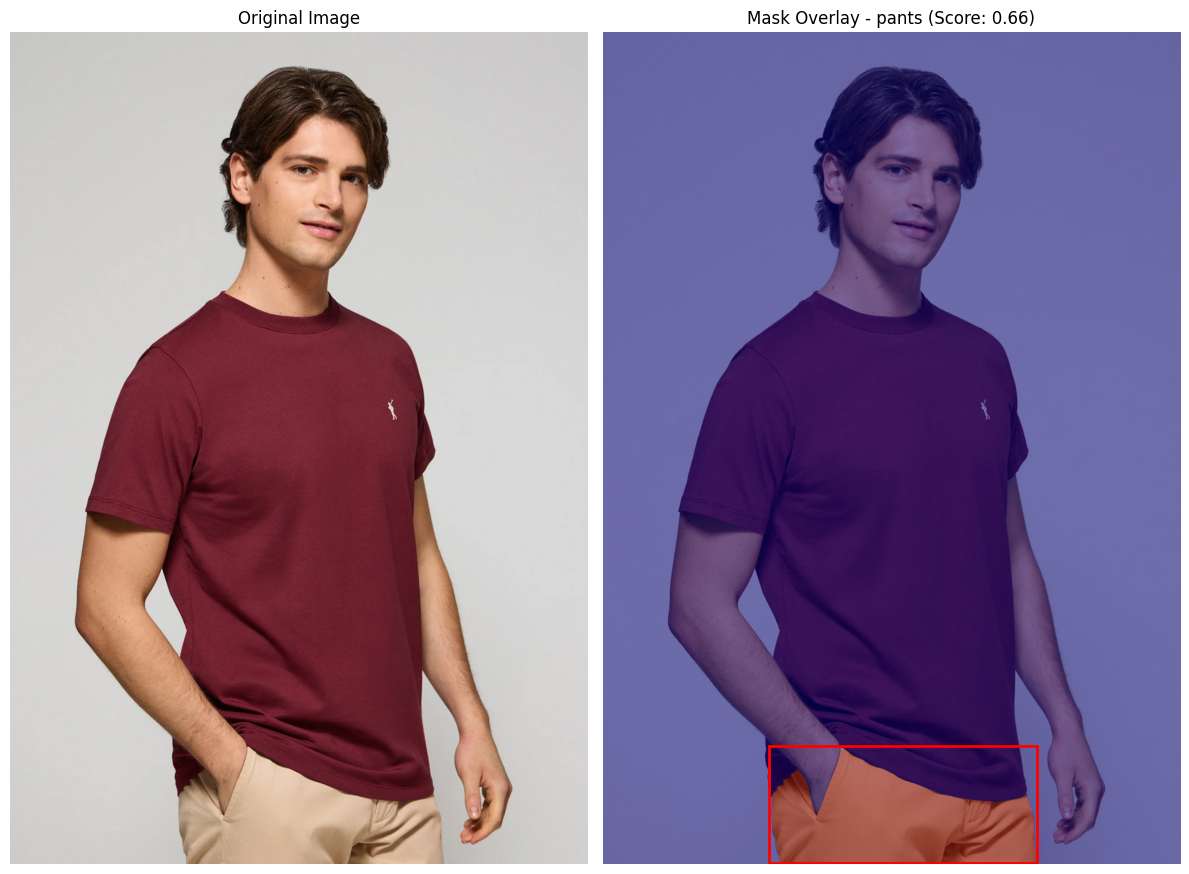

In [24]:

# Extract the mask from results
mask = masks[0]["masks"][0]
bbox = masks[0]["boxes"][0]
score = masks[0]["scores"][0]

# Create figure
plt.figure(figsize=(12, 10))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Plot mask overlay
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap="jet")
plt.title(f"Mask Overlay - {masks[0]['labels'][0]} (Score: {score:.2f})")
plt.axis("off")

# Add bounding box
x1, y1, x2, y2 = bbox
rect = plt.Rectangle(
    (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2
)
plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()
